# Example

In [1]:
# library
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.neural_network import MLPClassifier
import joblib
import os

# custom modules
from model import LogisticRegressionModels
import plotter
from preprocessing import load_and_preprocess


In [2]:
'''
data
'''
# data_train = pd.read_csv('./data/2016-09-19_79351_training.csv')
data_train = pd.read_csv("./data/2016-09-19_79351_training_feb_june.csv")
data_mcc_group = pd.read_csv('./data/mcc_group_definition.csv')
data_transaction = pd.read_csv('./data/transaction_types.csv')


In [3]:
data_train_main = data_train.copy()

In [4]:
data_train_main.head()

,user_id,transaction_date,transaction_type,mcc_group,amount_n26_currency,dataset_transaction,dataset_user
0,a78884f5e76951188c1e719d4956773a,01.02.16,DT,NaN,350,training,training
1,b0333294fef6ff1299102a70ad46b126,01.02.16,DT,NaN,202,training,training
2,7b8d2a2780adae0cd0c248e92c1b28dc,01.02.16,DT,NaN,291,training,training
3,cc4abaa500f7db4390ae3f02bd36d805,01.02.16,DT,NaN,214,training,training
4,49b99d1d5ba028566639e8b3eb7c055b,01.02.16,DT,NaN,272,training,training


In [5]:
data_train_main.dataset_transaction.unique(), data_train_main.dataset_user.unique()

(array(['training'], dtype=object), array(['training'], dtype=object))

In [6]:
data_train_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337560 entries, 0 to 337559
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   user_id              337560 non-null  object 
 1   transaction_date     337560 non-null  object 
 2   transaction_type     337560 non-null  object 
 3   mcc_group            213233 non-null  float64
 4   amount_n26_currency  337560 non-null  int64  
 5   dataset_transaction  337560 non-null  object 
 6   dataset_user         337560 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 18.0+ MB


In [7]:
data_train_main = data_train_main.drop(['dataset_transaction', 'dataset_user'], axis=1)

In [8]:
data_train_main.head(2)

,user_id,transaction_date,transaction_type,mcc_group,amount_n26_currency
0,a78884f5e76951188c1e719d4956773a,01.02.16,DT,NaN,350
1,b0333294fef6ff1299102a70ad46b126,01.02.16,DT,NaN,202


In [9]:
# data_transaction[data_transaction.direction == 'Out']

# print(data_transaction.type)

## Tasks
 - create ```direction``` (i.e. in/out) feature: the ```in``` and ```out``` represents the income and expenses, respectively. ```in``` denotes money coming into the user acccount and ```out``` denotes money going out of the user account.

 - creating month/day feature from the transaction date.

 - fill NAs in ```mcc_group``` with mode and miscellaneous. We will fill the NAs locally per user. Specifically, we will take the ```mcc_group``` of a user and check for the most frequent transaction type and use this mode to replace any NA for such user. In the event there is no mode, we will simply categorize this as miscellaneous (i.e. 16) since no modal value.

In [10]:
'''
filtered data_transaction based in transaction_type
'''

# filtering data_transaction.type

# data_train_main.user_id.nunique()
selected_types = list(data_train_main.transaction_type.unique()); selected_types
data_transaction_filtered = data_transaction[data_transaction.type.isin(selected_types)]

data_transaction_filtered.reset_index(drop = True, inplace = True); data_transaction_filtered

,type,explanation,direction,agent
0,BBU,Cash26 deposit,In,Partner
1,CT,Credit Transfer,In,Bank Account
2,DR,Debit Reversal,In,Bank Account
3,BUB,Cash26 withdrawal,Out,Partner
4,DD,Direct Debit,Out,Bank Account
5,DT,Debit Transfer,Out,Bank Account
6,FT,MoneyBeam Transfer,Out,Bank Account
7,PT,Presentment,Out,Card
8,TUB,Transferwise Transaction,Out,Partner


In [11]:
data_transaction_filtered[data_transaction_filtered.direction == 'In'].type

0    BBU
1     CT
2     DR
Name: type, dtype: object

In [12]:
data_transaction_filtered[data_transaction_filtered.direction == 'Out'].type

3    BUB
4     DD
5     DT
6     FT
7     PT
8    TUB
Name: type, dtype: object

In [13]:
type_in = data_transaction_filtered[data_transaction_filtered.direction == 'In'].type
type_out = data_transaction_filtered[data_transaction_filtered.direction == 'Out'].type
type_in, type_out = list(type_in), list(type_out); 
type_in, type_out

(['BBU', 'CT', 'DR'], ['BUB', 'DD', 'DT', 'FT', 'PT', 'TUB'])

In [14]:
data_train_main.head()

,user_id,transaction_date,transaction_type,mcc_group,amount_n26_currency
0,a78884f5e76951188c1e719d4956773a,01.02.16,DT,NaN,350
1,b0333294fef6ff1299102a70ad46b126,01.02.16,DT,NaN,202
2,7b8d2a2780adae0cd0c248e92c1b28dc,01.02.16,DT,NaN,291
3,cc4abaa500f7db4390ae3f02bd36d805,01.02.16,DT,NaN,214
4,49b99d1d5ba028566639e8b3eb7c055b,01.02.16,DT,NaN,272


In [15]:
## adding in/out feature to data_train_main

data_train_main['direction'] = data_train_main.transaction_type.apply(lambda x: 'In' if x in type_in else 'Out')

In [16]:
# mapping

type_to_agent = {
    'BBU': 'Partner',
    'CT': 'Bank Account',
    'DR': 'Bank Account',
    'PF': 'Card',
    'PT': 'Card',
    'BUB': 'Partner',
    'DD': 'Bank Account',
    'DT': 'Bank Account',
    'FT': 'Bank Account',
    'TUB': 'Partner'
}

data_train_main['agent'] = data_train_main.transaction_type.apply(lambda x: type_to_agent[x])

In [17]:
data_train_main[data_train_main.transaction_type == 'PT']

,user_id,transaction_date,transaction_type,mcc_group,amount_n26_currency,direction,agent
526,bf84257bf1b24c4cd05bae3f5ab14b0f,01.02.16,PT,4.0,15,Out,Card
528,86c37c519ed3516d079fc687c9357eb9,01.02.16,PT,7.0,4,Out,Card
531,9fed9cf27088374646d08b2356783c25,01.02.16,PT,2.0,6,Out,Card
532,9fed9cf27088374646d08b2356783c25,01.02.16,PT,2.0,4,Out,Card
535,2d907dc31f7432c76d3700f9044fa562,01.02.16,PT,8.0,17,Out,Card
...,...,...,...,...,...,...,...
337038,9d58b8d99ce87647e156c1c6b80f535c,30.06.16,PT,12.0,7,Out,Card
337039,a71164041a6a1210f0ee2b30c6b24148,30.06.16,PT,12.0,194,Out,Card
337040,58ca84e181b7a63c24f685f4c4e04bc5,30.06.16,PT,1.0,38,Out,Card
337041,2331ec0969b65cfaa3c8df16a3cd5ec7,30.06.16,PT,1.0,70,Out,Card


In [18]:
# df3 = data_train_main[data_train_main.direction == 'Out']
# df3.transaction_type.unique()

=====================================

In [19]:
# extract day/month from data_train_main.transaction_date
data_train_main['transaction_date'] = pd.to_datetime(data_train_main.transaction_date)

<ipython-input-19-c59819a4095d>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_train_main['transaction_date'] = pd.to_datetime(data_train_main.transaction_date)


In [20]:
data_train_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337560 entries, 0 to 337559
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   user_id              337560 non-null  object        
 1   transaction_date     337560 non-null  datetime64[ns]
 2   transaction_type     337560 non-null  object        
 3   mcc_group            213233 non-null  float64       
 4   amount_n26_currency  337560 non-null  int64         
 5   direction            337560 non-null  object        
 6   agent                337560 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 18.0+ MB


In [21]:
data_train_main['day'] = data_train_main.transaction_date.dt.day
data_train_main['month'] = data_train_main.transaction_date.dt.month

In [22]:
data_train_main.head()

,user_id,transaction_date,transaction_type,mcc_group,amount_n26_currency,direction,agent,day,month
0,a78884f5e76951188c1e719d4956773a,2016-01-02,DT,NaN,350,Out,Bank Account,2,1
1,b0333294fef6ff1299102a70ad46b126,2016-01-02,DT,NaN,202,Out,Bank Account,2,1
2,7b8d2a2780adae0cd0c248e92c1b28dc,2016-01-02,DT,NaN,291,Out,Bank Account,2,1
3,cc4abaa500f7db4390ae3f02bd36d805,2016-01-02,DT,NaN,214,Out,Bank Account,2,1
4,49b99d1d5ba028566639e8b3eb7c055b,2016-01-02,DT,NaN,272,Out,Bank Account,2,1


=====================================

In [23]:
# data_train_main_fill[data_train_main_fill['user_id']=='000295594379774ab9ac2c78c946d615']

In [24]:
def fill_missing_with_mode(df, group_col, target_col):
    
    def mode_function(x):
        modes = x.mode()
        if not modes.empty:
            return modes[0]
        else:
            return 16 #miscellaneous
    
    df[target_col] = df.groupby(group_col)[target_col].transform(lambda x: x.fillna(mode_function(x)))
    
    return df


data_train_main_filled = fill_missing_with_mode(data_train_main, 'user_id', 'mcc_group')


In [25]:
data_train_main_filled[data_train_main_filled['user_id']=='001f9baedaf3c8487c344d25b0eda9fc']

,user_id,transaction_date,transaction_type,mcc_group,amount_n26_currency,direction,agent,day,month
10443,001f9baedaf3c8487c344d25b0eda9fc,2016-04-02,BBU,6.0,19,In,Partner,2,4
37887,001f9baedaf3c8487c344d25b0eda9fc,2016-02-18,PT,6.0,5,Out,Card,18,2
40685,001f9baedaf3c8487c344d25b0eda9fc,2016-02-19,PT,8.0,9,Out,Card,19,2
55226,001f9baedaf3c8487c344d25b0eda9fc,2016-02-27,PT,6.0,5,Out,Card,27,2
80262,001f9baedaf3c8487c344d25b0eda9fc,2016-08-03,CT,6.0,58,In,Bank Account,3,8
86543,001f9baedaf3c8487c344d25b0eda9fc,2016-11-03,PT,6.0,4,Out,Card,3,11
92413,001f9baedaf3c8487c344d25b0eda9fc,2016-03-15,PT,6.0,6,Out,Card,15,3
95978,001f9baedaf3c8487c344d25b0eda9fc,2016-03-16,PT,16.0,4,Out,Card,16,3
99827,001f9baedaf3c8487c344d25b0eda9fc,2016-03-17,CT,6.0,4,In,Bank Account,17,3
104097,001f9baedaf3c8487c344d25b0eda9fc,2016-03-20,PT,2.0,11,Out,Card,20,3


<Axes: xlabel='mcc_group'>

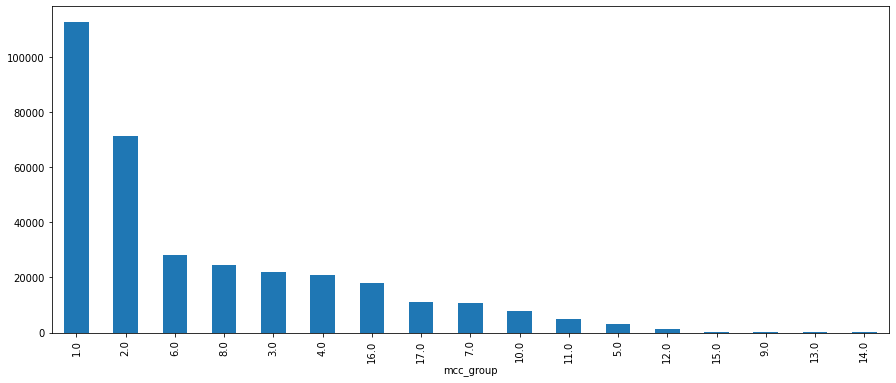

In [26]:
# before fill

plt.figure(figsize=(15, 6))
data_train_main.mcc_group.value_counts().plot(kind = 'bar')

<Axes: xlabel='mcc_group'>

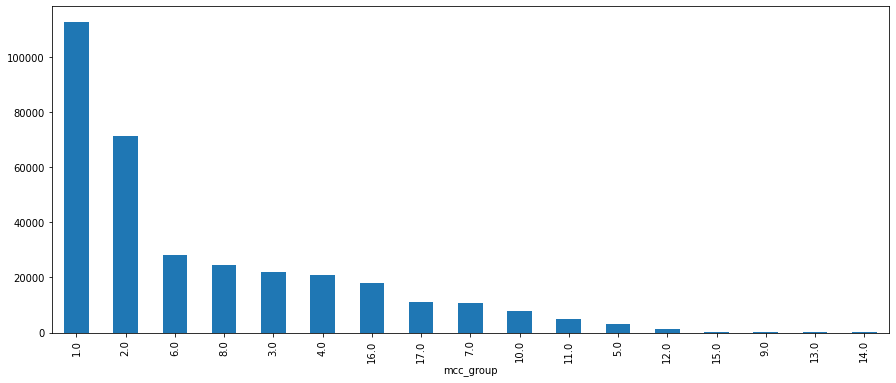

In [27]:
# after fill

plt.figure(figsize=(15, 6))
data_train_main_filled.mcc_group.value_counts().plot(kind = 'bar')

# checking distribution of response feature

<Axes: xlabel='direction'>

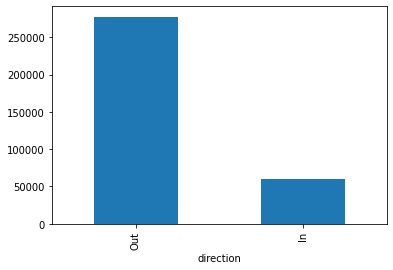

In [28]:
data_train_main_filled.direction.value_counts().plot(kind = 'bar')

In [29]:
data_train_main_filled.direction.value_counts(normalize=True) * 100

direction
Out    82.196647
In     17.803353
Name: proportion, dtype: float64

## Feature engineering

In [30]:
data_train_main_filled.head()

,user_id,transaction_date,transaction_type,mcc_group,amount_n26_currency,direction,agent,day,month
0,a78884f5e76951188c1e719d4956773a,2016-01-02,DT,8.0,350,Out,Bank Account,2,1
1,b0333294fef6ff1299102a70ad46b126,2016-01-02,DT,7.0,202,Out,Bank Account,2,1
2,7b8d2a2780adae0cd0c248e92c1b28dc,2016-01-02,DT,1.0,291,Out,Bank Account,2,1
3,cc4abaa500f7db4390ae3f02bd36d805,2016-01-02,DT,1.0,214,Out,Bank Account,2,1
4,49b99d1d5ba028566639e8b3eb7c055b,2016-01-02,DT,17.0,272,Out,Bank Account,2,1


In [31]:
data_train_main_filled.direction.value_counts()

direction
Out    277463
In      60097
Name: count, dtype: int64

In [32]:
# encoding categorical columns

categorical_cols = data_train_main_filled.select_dtypes(include = 'object').columns
print(f'categorical_cols:{categorical_cols}')
for col in categorical_cols[1:]:
    data_train_main_filled[col] = LabelEncoder().fit_transform(data_train_main_filled[col])

categorical_cols:Index(['user_id', 'transaction_type', 'direction', 'agent'], dtype='object')


In [33]:
# set mcc_group into integer

data_train_main_filled['mcc_group'] = data_train_main_filled['mcc_group'].astype(int)

In [34]:
data_train_main_filled.head()

,user_id,transaction_date,transaction_type,mcc_group,amount_n26_currency,direction,agent,day,month
0,a78884f5e76951188c1e719d4956773a,2016-01-02,5,8,350,1,0,2,1
1,b0333294fef6ff1299102a70ad46b126,2016-01-02,5,7,202,1,0,2,1
2,7b8d2a2780adae0cd0c248e92c1b28dc,2016-01-02,5,1,291,1,0,2,1
3,cc4abaa500f7db4390ae3f02bd36d805,2016-01-02,5,1,214,1,0,2,1
4,49b99d1d5ba028566639e8b3eb7c055b,2016-01-02,5,17,272,1,0,2,1


In [35]:
data_train_main_filled.direction.value_counts()

direction
1    277463
0     60097
Name: count, dtype: int64

In [36]:
data_train_main_filled.direction.value_counts()

direction
1    277463
0     60097
Name: count, dtype: int64

In [37]:
df2 = data_train_main_filled.copy()
df2.drop(['user_id', 'transaction_date'], axis=1, inplace=True)
df3 = df2.copy()
df3.drop(['transaction_type'], axis=1, inplace=True)
# df3.drop(['direction'], axis=1, inplace=True)

In [38]:
df2.corr()

,transaction_type,mcc_group,amount_n26_currency,direction,agent,day,month
transaction_type,1.000000,0.096101,-0.342948,0.813946,0.748619,0.002256,0.064226
mcc_group,0.096101,1.000000,-0.063145,0.058669,0.100982,-0.005984,0.012564
amount_n26_currency,-0.342948,-0.063145,1.000000,-0.357703,-0.283742,0.046683,-0.034658
direction,0.813946,0.058669,-0.357703,1.000000,0.514057,-0.016038,0.034238
agent,0.748619,0.100982,-0.283742,0.514057,1.000000,0.004547,0.064605
day,0.002256,-0.005984,0.046683,-0.016038,0.004547,1.000000,-0.327059
month,0.064226,0.012564,-0.034658,0.034238,0.064605,-0.327059,1.000000


## splitting

In [39]:
df3.head(3)

,mcc_group,amount_n26_currency,direction,agent,day,month
0,8,350,1,0,2,1
1,7,202,1,0,2,1
2,1,291,1,0,2,1


In [40]:
# split data

X = df3.drop('direction', axis=1)
y = df3['direction']

In [41]:
'''
split data
'''

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


In [42]:
y_train.shape, y_val.shape, y_test.shape

((270048,), (33756,), (33756,))

In [43]:
y_train.value_counts(normalize=True) * 100, y_val.value_counts(normalize=True) * 100, y_test.value_counts(normalize=True) * 100

(direction
 1    82.196498
 0    17.803502
 Name: proportion, dtype: float64,
 direction
 1    82.19872
 0    17.80128
 Name: proportion, dtype: float64,
 direction
 1    82.195758
 0    17.804242
 Name: proportion, dtype: float64)

In [44]:
y_train.value_counts(normalize=True) * 100

direction
1    82.196498
0    17.803502
Name: proportion, dtype: float64

In [45]:
'''
grids search on RF
'''

run_grid_search = False
if run_grid_search:
    
    param_grid = {
        'class_weight': [{0: 1.3, 1: 1.0},{0: 1.4, 1: 1.0}, {0: 1.45, 1: 1.0}, {0: 1.5, 1: 1.0}],
        # 'class_weight': [{0: 2.8, 1: 0.6}, {0: 2.4, 1: 0.6},  {0: 2.2, 1: 0.6}],
        'n_estimators': [50, 100],
        'max_depth': [None, 10, 20],
    }
    

    grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, scoring='roc_auc', cv=3, verbose=3)
   
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_;best_params
    print("Best parameters:", best_params)

# Methods

![title](../scripts/img/lr.png)
## 1. LR (logistic regression): 
we use the LR methods as baseline and in addition, we add penalties to the cost function to balance the target variable.

## 2. RF (random forest)

![title](img/rfTree.png)
`(image source: https://upload.wikimedia.org/wikipedia/commons/4/4e/Random_forest_explain.png)`

In classification problem, the RF method works by constructing multiple decision trees during training and returns the majority vote from these trees.

baseline RF assumes equal importance for all classes, and the weighted approach introduces class weights to modify the splitting criteria of the labels to prioritize minority class.

## 3. MLP (multilayer perceptron)
mlp is a feedforward neural network consisting of fully connected neurons with nonlinear activation functions 





paramter:

- `class_weight`: in the weighted RF, changes to `class_weight` will modify the outcome of the model. after some experiments, the class weight is set as `class_weight={0:1.45, 1:1.0}`
- `max_depth`: the maximum depth of the tree
- `n_estimator`: higher (lower) `n_estimator` could increase (reduce) model accuracy
- weights on LR: to tune the model sensitivity to imbalanced response feature, use `weight_positive=1.` and  `weight_negative=1.45`. these values are thesame as in `class_weight`
- `hidden_layer_sizes`: The ith element represents the number of neurons in the ith hidden layer.
- `activation`: activation function for the hidden layer. other options are {identity, logistic, tanh}.
- `solver`: the solver for weight optimization. other options to try are `lbfgs` and `sgd`.

In [46]:
'''
train model
'''

n_estimator = 100
seedS = 42
lr = 0.01
max_iter = 1000
max_depth = 15

models = {
    "Baseline RF": RandomForestClassifier(n_estimators=n_estimator, random_state=seedS),
    "Weighted RF": RandomForestClassifier(n_estimators=n_estimator, class_weight={0:1.45, 1:1.0}, max_depth=max_depth, random_state=seedS),
    "Baseline LR": LogisticRegressionModels(model_type="baseline", learning_rate=lr, max_iter=max_iter),
    "cost LR": LogisticRegressionModels(model_type="cost_sensitive", weight_positive=1., weight_negative=1.45, learning_rate=lr, max_iter=max_iter),
    "MLP": MLPClassifier(hidden_layer_sizes=(50,), activation='relu', solver='adam', verbose=True,learning_rate_init=lr, max_iter=max_iter, random_state=seedS),
} #relu

results = {}
for name, model in models.items():
    print(f"Training {name}")
    if model.__class__.__name__ in ['RandomForestClassifier', 'MLPClassifier']:
        model.fit(X_train, y_train)
    elif model.__class__.__name__ == 'LogisticRegressionModels':
        model.fit(X_train, y_train, X_val, y_val)
    else:
        raise ValueError("Model not supported")
        
    show_curves = False
    if show_curves:
        if isinstance(model, (LogisticRegressionModels)):  
            plt.figure(figsize=(10, 6))
            plt.plot(model.train_losses, label='Training Loss')
            plt.plot(model.val_losses, label='Validation Loss')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.title(f'{name} Training and Validation Loss Curves')
            plt.legend()
            plt.grid()
            plt.show()

    # pred
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    y_pred_test = model.predict(X_test)
    

    # metric
    train_accuracy = accuracy_score(y_train, y_pred_train)
    val_accuracy = accuracy_score(y_val, y_pred_val)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    f1 = f1_score(y_test, y_pred_test)
    
    if model.__class__.__name__ in ['RandomForestClassifier', 'MLPClassifier']:
        y_pred_proba_test = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_pred_proba_test)
    elif model.__class__.__name__ == 'LogisticRegressionModels':
        y_pred_proba_test = model.predict_proba(X_test)
        auc = roc_auc_score(y_test, y_pred_proba_test)

    # Save model
    joblib.dump(model, f"models/{name.replace(' ', '_')}_model.pkl")
    
    results[name] = {
        "Train Accuracy": train_accuracy,
        "Val Accuracy": val_accuracy,
        "Test Accuracy": test_accuracy,
        "AUC": auc,
        "f1": f1,
        "Model": model,
        }
    print(f"--- {name} saved ---")
    print(f"Train Accuracy: {train_accuracy:.2f}")
    print(f"Val Accuracy: {val_accuracy:.2f}")
    print(f"Test Accuracy: {test_accuracy:.2f}")

Training Baseline RF
--- Baseline RF saved ---
Train Accuracy: 0.94
Val Accuracy: 0.86
Test Accuracy: 0.86
Training Weighted RF
--- Weighted RF saved ---
Train Accuracy: 0.90
Val Accuracy: 0.87
Test Accuracy: 0.87
Training Baseline LR
--- Baseline LR saved ---
Train Accuracy: 0.85
Val Accuracy: 0.85
Test Accuracy: 0.85
Training cost LR
--- cost LR saved ---
Train Accuracy: 0.86
Val Accuracy: 0.86
Test Accuracy: 0.86
Training MLP
Iteration 1, loss = 0.24836411
Iteration 2, loss = 0.23823900
Iteration 3, loss = 0.23744604
Iteration 4, loss = 0.23690349
Iteration 5, loss = 0.23666980
Iteration 6, loss = 0.23628857
Iteration 7, loss = 0.23633570
Iteration 8, loss = 0.23603214
Iteration 9, loss = 0.23549679
Iteration 10, loss = 0.23553718
Iteration 11, loss = 0.23525665
Iteration 12, loss = 0.23527474
Iteration 13, loss = 0.23522303
Iteration 14, loss = 0.23505951
Iteration 15, loss = 0.23500486
Iteration 16, loss = 0.23495118
Iteration 17, loss = 0.23486919
Iteration 18, loss = 0.23479075


In [47]:
methods = list(results.keys())
test_accuracies_ = [metrics['Test Accuracy'] for metrics in results.values()]

list(zip(methods,test_accuracies_))

[('Baseline RF', 0.8625725796895367),
 ('Weighted RF', 0.8725856144092902),
 ('Baseline LR', 0.8491231188529447),
 ('cost LR', 0.8611802346249555),
 ('MLP', 0.869504680649366)]

In [48]:
[('Baseline RF', 0.8636397013829397), ('Weighted RF', 0.8698323338636642)]

[('Baseline RF', 0.8636397013829397), ('Weighted RF', 0.8698323338636642)]

In [49]:
def plot_barplot(
    indices,
    train_accuracies,
    val_accuracies,
    test_accuracies,
    labels,
    bar_width=0.1,
    figsize=(12, 6),
):

    plt.figure(figsize=figsize)
    plt.bar(indices, train_accuracies, width=bar_width, label="training", alpha=0.8)
    plt.bar(
        indices + bar_width,
        val_accuracies,
        width=bar_width,
        label="validation",
        alpha=0.8,
    )
    plt.bar(
        indices + 2 * bar_width,
        test_accuracies,
        width=bar_width,
        label="test",
        alpha=0.8,
    )

    plt.xlabel("Model", fontsize=14)
    plt.ylabel("Accuracy", fontsize=14)
    plt.xticks(indices + bar_width, labels, rotation=0)
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()


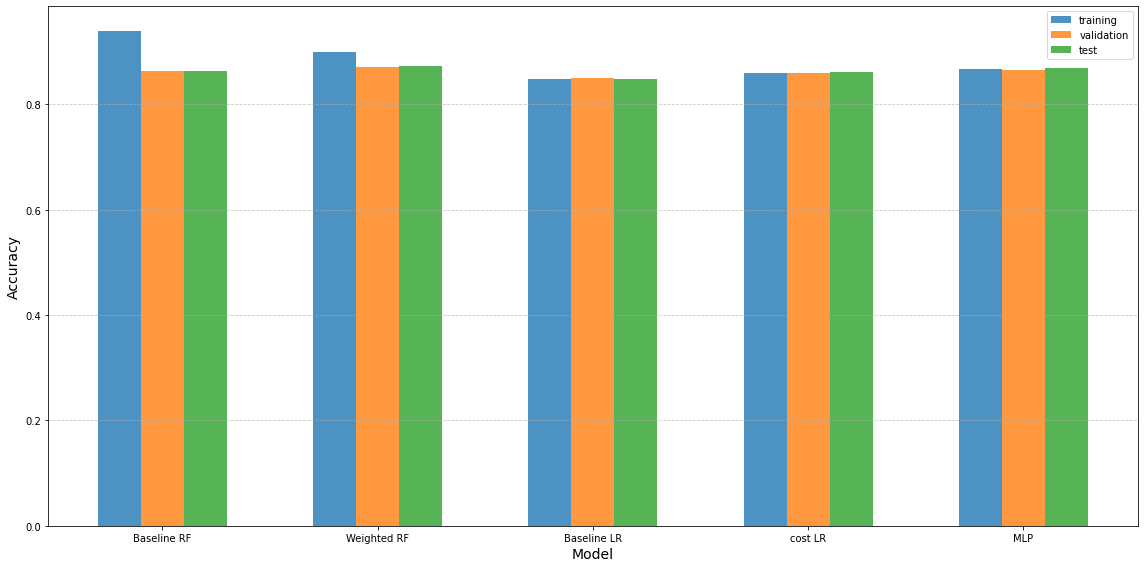

In [50]:
'''
plot accuraries
'''

labels = list(results.keys())
train_accuracies = [metrics['Train Accuracy'] for metrics in results.values()]
val_accuracies = [metrics['Val Accuracy'] for metrics in results.values()]
test_accuracies = [metrics['Test Accuracy'] for metrics in results.values()]

bar_width = 0.2
indices = np.arange(len(labels))
figsize = (16, 8)
plotter.plot_barplot( indices, train_accuracies, val_accuracies, test_accuracies, labels, bar_width=bar_width, figsize=figsize)


In [51]:
results['Baseline RF']

{'Train Accuracy': 0.9391404491053442,
 'Val Accuracy': 0.864290792747956,
 'Test Accuracy': 0.8625725796895367,
 'AUC': 0.9192379396505477,
 'f1': 0.9166771441400988,
 'Model': RandomForestClassifier(random_state=42)}

In [52]:
test_accuracies_2 = [metrics['Test Accuracy'] for metrics in results.values()]

list(zip(methods,test_accuracies_2))

[('Baseline RF', 0.8625725796895367),
 ('Weighted RF', 0.8725856144092902),
 ('Baseline LR', 0.8491231188529447),
 ('cost LR', 0.8611802346249555),
 ('MLP', 0.869504680649366)]

In [53]:
auc_ = [metrics['AUC'] for metrics in results.values()]

list(zip(methods,auc_))

[('Baseline RF', 0.9192379396505477),
 ('Weighted RF', 0.9343544535747564),
 ('Baseline LR', 0.871748742125051),
 ('cost LR', 0.871807535507809),
 ('MLP', 0.9279742531279411)]

In [54]:
f1_ = [metrics['f1'] for metrics in results.values()]

list(zip(methods,f1_))

[('Baseline RF', 0.9166771441400988),
 ('Weighted RF', 0.9213610516885159),
 ('Baseline LR', 0.9136882064839764),
 ('cost LR', 0.9180167255677246),
 ('MLP', 0.9218347972673232)]

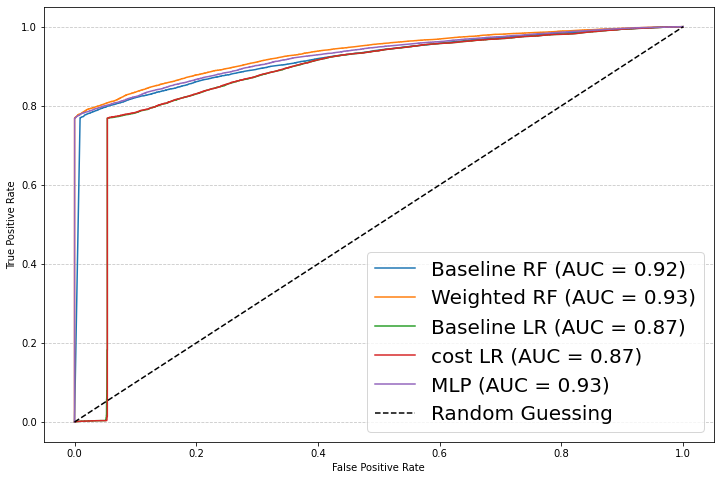

In [55]:
'''
plot AUC curves
'''
from sklearn.metrics import roc_curve

def plot_auc_curves(results, X_test, y_test, figsize=(10, 6)):
    """
    ROC curves here.
    """
    plt.figure(figsize=figsize)
    for name, metrics in results.items():
        model = metrics["Model"]
        if model.__class__.__name__ in ['RandomForestClassifier', 'MLPClassifier']:
            y_pred_proba_test = model.predict_proba(X_test)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba_test)
        elif model.__class__.__name__ == 'LogisticRegressionModels':
            y_pred_proba_test = model.predict_proba(X_test)
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba_test)
        else:
            continue 
        
        plt.plot(fpr, tpr, label=f'{name} (AUC = {metrics["AUC"]:.2f})')
    plt.plot([0, 1], [0, 1], "k--", label="Random Guessing")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="best", fontsize=20)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

figsize=(12, 8)
plotter.plot_auc_curves(results, X_test, y_test, figsize=figsize)

## Test case

In [56]:
import importlib
from preprocessing import load_and_preprocess
import preprocessing2 #import load_and_preprocessT

# lets compare `new_data` with `predict_df`

In [69]:
output_csv_path = "./result/predictions_all_models.csv"
prediction_df_ = pd.read_csv(output_csv_path)
prediction_df_.head()

,Baseline_LR_prediction,Baseline_LR_meaning,Baseline_LR_probability,Baseline_RF_prediction,Baseline_RF_meaning,Baseline_RF_probability,Weighted_RF_prediction,Weighted_RF_meaning,Weighted_RF_probability,Cost-sensitive_LR_prediction,Cost-sensitive_LR_meaning,Cost-sensitive_LR_probability,MLP_prediction,MLP_meaning,MLP_probability
0,0,In,1.416394e-43,0,In,0.3725,0,In,0.341104,0,In,1.244572e-49,0,In,1.459896e-07
1,0,In,2.185507e-37,0,In,0.1600,0,In,0.171639,0,In,1.373175e-42,0,In,5.842439e-07
2,0,In,3.889676e-75,0,In,0.1400,0,In,0.217397,0,In,1.504343e-85,0,In,1.586080e-10
3,0,In,2.227612e-04,0,In,0.3725,0,In,0.341104,0,In,5.113552e-05,0,In,1.628183e-02
4,0,In,1.405608e-02,0,In,0.1400,0,In,0.217397,0,In,5.827044e-03,0,In,9.510073e-02


In [70]:
new_data_dir = "./data/2016-09-19_79351_training_july.csv" # August data
new_data = preprocessing2.load_and_preprocessT(new_data_dir, training=False)

new_data.head(2)

original df shape: (70986, 7)
actual False


/Users/abdullahi/Documents/interview/n26/src/preprocessing2.py:56: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_train["transaction_date"] = pd.to_datetime(df_train["transaction_date"])


categorical_cols:Index(['direction', 'agent'], dtype='object')
y:<class 'pandas.core.series.Series'>
using --training == predict--


,mcc_group,amount_n26_currency,direction,agent,day,month
0,2,202,1,0,7,1
1,1,173,1,0,7,1


In [71]:
prediction_df = prediction_df_.copy()
if len(new_data) != len(prediction_df):
    raise ValueError("df1 and df2 must have the same number of rows!")

prediction_columns = [col for col in prediction_df.columns if col.endswith('_prediction')]

    
comparison_results = pd.DataFrame(index=new_data.index)
comparison_results["Actual_Direction"] = new_data["direction"]

accuracy_scores = {}
for col in prediction_columns:
    comparison_results[col] = prediction_df[col] == new_data["direction"]  
    accuracy_scores[col] = (comparison_results[col].sum() / len(comparison_results)) * 100




In [72]:
comparison_results

,Actual_Direction,Baseline_LR_prediction,Baseline_RF_prediction,Weighted_RF_prediction,Cost-sensitive_LR_prediction,MLP_prediction
0,1,False,False,False,False,False
1,1,False,False,False,False,False
2,1,False,False,False,False,False
3,1,False,False,False,False,False
4,1,False,False,False,False,False
...,...,...,...,...,...,...
70981,1,False,False,False,False,True
70982,1,False,False,False,False,False
70983,1,False,False,False,False,True
70984,1,False,False,False,False,True


In [ ]:
STOP

# appendix

In [ ]:
new_data_dir = "./data/2016-09-19_79351_training_july.csv" # August data
model_dir = "./models"
output_csv_path = "./result/predictions_all_models.csv"
print("Loading preprocessing artifacts...")
   
print("Loading new data...")

new_data = load_and_preprocess(new_data_dir, training=False)
print(new_data.head())

model_files = [f for f in os.listdir(model_dir) if f.endswith("_model.pkl")]

all_predictions = {}

for model_file in model_files:
    model_path = os.path.join(model_dir, model_file)
    model = joblib.load(model_path)

    model_name = model_file.replace("_model.pkl", "")

    print(f"Making predictions with {model_name}...")

    # Predict
    class_predictions = model.predict(new_data)
    print(f"Predictions made:{class_predictions}")
    all_predictions[f"{model_name}_prediction"] = class_predictions

    pred_meaning = {0: "In", 1: "Out"}
    print(f"pred_meaning added")
    all_predictions[f"{model_name}_meaning"] = [
        pred_meaning[pred] for pred in class_predictions
    ]

    if model.__class__.__name__ in ["RandomForestClassifier", "MLPClassifier"]:
        y_pred_proba_test = model.predict_proba(new_data)[:, 1]
    elif model.__class__.__name__ == "LogisticRegressionModels":
        y_pred_proba_test = model.predict_proba(new_data)
    else:
        y_pred_proba_test = None

    if y_pred_proba_test is not None:
        all_predictions[f"{model_name}_probability"] = y_pred_proba_test

prediction_df = pd.DataFrame(all_predictions)

if output_csv_path is not None:
    prediction_df.to_csv(output_csv_path, index=False)

print(f"Predictions saved to {output_csv_path}")
